In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('mnist',train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist',train=False, transform=transform)
train_loader = DataLoader(train_dataset, num_workers=2,shuffle=True,batch_size=100)
test_loader = DataLoader(test_dataset, num_workers=2,shuffle=True,batch_size=100)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class SoftMaxNet(nn.Module):
    def __init__(self):
        super(SoftMaxNet, self).__init__()
        self.conv_layer = nn.Sequential(
            # 32 1 28 28
            nn.Conv2d(1, 256, 5),
            # 32 256 24 24
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 32 256 12 12
            nn.Conv2d(256, 256, 3),
            # 32 256 10 10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 32 256 5 5
            nn.Conv2d(256, 2, 5),
            # 32 2 1 1 
            nn.AdaptiveAvgPool2d(1),)
        self.classifier = nn.Linear(2, 10)
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.shape[0], 2)
        x = self.classifier(x)
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.conv_layer(x)
            x = x.view(x.shape[0], 2)
            x = F.normalize(x)
            return x

In [6]:
softmax_net = SoftMaxNet().to(device)
learning_rate = 0.1
criterion = nn.CrossEntropyLoss() # softmax 이미 포함
optimizer = optim.SGD(softmax_net.parameters(), lr=learning_rate)

In [7]:
train_losses = []
train_accuracy = []

In [8]:
def train(net,epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = outputs.max(1)

        total += labels.size(0)
        correct += prediction.eq(labels).sum().item()

        if batch_idx % 500 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current train accuracy:', str(prediction.eq(labels).sum().item() / labels.size(0)))
            print('Current train average loss:', loss.item() / 100)


    train_losses.append(train_loss / total)
    train_accuracy.append(100. * correct / total)
    print('\nTrain accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)


def test(net,epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        outputs = net(images)
        loss += criterion(outputs, labels).item()

        _, prediction = outputs.max(1)
        correct += prediction.eq(labels).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

In [9]:
for epoch in range(0,20) :
    train(softmax_net,epoch)


[ Train epoch: 0 ]


TypeError: 'tuple' object is not callable

In [10]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

In [11]:
def get_samples_vector(net, dataloader, num_samples=1000):
    samples = []
    labels = []
    for x, y in dataloader:
        sample = net.get_feature(x.cuda()) # normalized vector
        samples.extend(sample.tolist())
        labels.extend(y.tolist())
        if len(samples) > num_samples:
            break
    samples = list(zip(samples, labels))
    return samples, labels

In [12]:
def show_2d_space(samples, labels, w):
    plt.figure(figsize=(10,10))
    for i in range(10):
        samples_i = list(filter(lambda x : x[1] == i, samples))
        samples_feat = np.ndarray.flatten(np.array([s[0] for s in samples_i]))
        plt.plot(*samples_feat, marker="o", color=colors[i], markersize=1)
        plt.plot([w[i][0], 0], [w[i][1], 0], color=colors[i])
    # plt.plot(*zip(w, [[0,0] for i in range(10)]))
    plt.show()

In [19]:
softmax_net.classifier

Linear(in_features=2, out_features=10, bias=True)

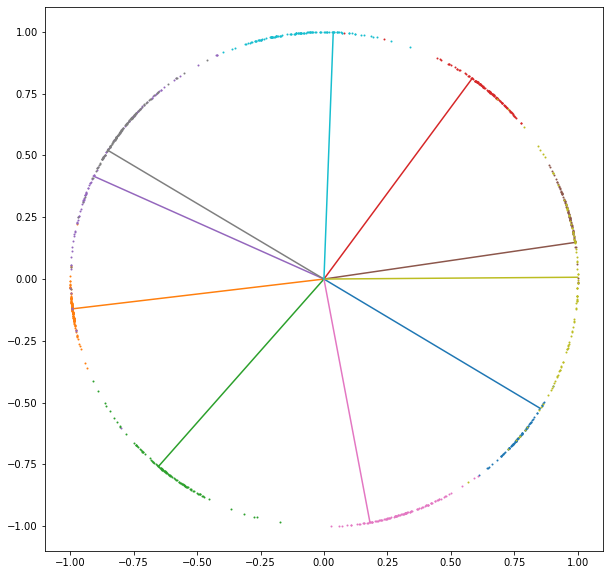

In [15]:
softmax_samples, softmax_labels = get_samples_vector(softmax_net, dataloader=train_loader, num_samples=1000)
softmax_w = F.normalize(softmax_net.classifier.weight).tolist()
show_2d_space(softmax_samples, softmax_labels, softmax_w)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("losses")
plt.plot(train_losses, label="train loss") 
plt.xlabel("iterations") 
plt.ylabel("Loss") 
plt.legend() 
plt.show()